## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def store_image(img, img_dir, fname):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    img_path = img_dir + fname.split('/')[-1]
    #print(img_path)
    cv2.imwrite(img_path, img)
        
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #store every images with detected corners for post analyse and writeup
            img_dir = 'output_images/chessboard_corners/'
            img_path = img_dir + fname.split('/')[-1]
            store_image(img, img_dir, img_path)
    #calibrate camera with identified objpoints and imgpoints
    img_size = (img.shape[1], img.shape[0])
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(150, 255), sx_thresh=(20, 200),l_thresh=(50,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    return  combined_binary

def warp(img,src2dst=True):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[585, 460],[203, 720],[1127, 720],[695, 460]])
    dst = np.float32([[320, 0],[320, 720],[960, 720],[960, 0]])
    #print(src, dst)
    
    if src2dst:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0,0),2)    

# Calibrate camera

In [2]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

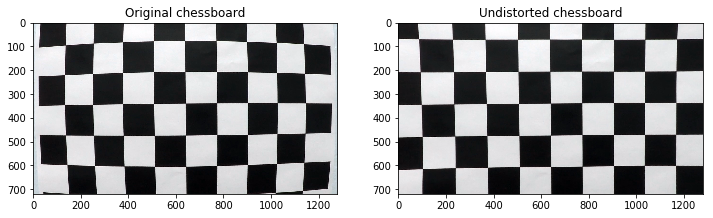

In [27]:
#test on chess board
cb = cv2.imread('camera_cal/calibration1.jpg')
undist_cb = undistort(cb)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(cb)
plt.title("Original chessboard")
plt.subplot(2, 2, 2)
plt.imshow(undist_cb)
plt.title("Undistorted chessboard")

plt.savefig('output_images/undistorted_cb.jpg')

## Test pipeline on test images and store output

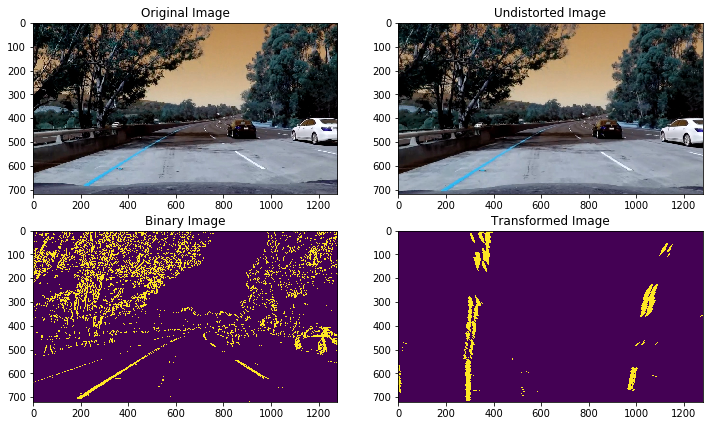

In [12]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

def preprocess_img(img):
    undist_img = undistort(img)
    binary_image = pipeline(undist_img)
    transformed = warp(binary_image)
    region_sel  = region_of_interest(transformed)
    return region_sel

# process test images
for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort(img)
    #draw_lines(undist_img, src)
    store_image(undist_img, 'output_images/undistorted/', fname)
    binary_image = pipeline(undist_img)
    store_image(binary_image*255, 'output_images/binary_images/', fname)
    #transformed = transform(undist_img, src, dst)
    transformed = warp(binary_image)
    region_sel  = region_of_interest(transformed)
    store_image(region_sel*255, 'output_images/transformed_images/', fname)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undist_img)
plt.title("Undistorted Image")
#img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(binary_image*255)
plt.title("Binary Image")
plt.subplot(2, 2, 4)
plt.imshow(transformed*255)
plt.title("Transformed Image")

In [13]:
def detect_start(binary_warped, LL, RL, fname=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #plot
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    LL.update_params(left_fit, right_fit, leftx, lefty, ploty)
    RL.update_params(right_fit, left_fit, rightx, righty, ploty)
    
    if(fname!=None):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(fname)

#next frame fit poly
def detect_next(binary_warped, LL, RL):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] - margin)) & (nonzerox < (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] - margin)) & (nonzerox < (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    LL.update_params(left_fit, right_fit, leftx, lefty, ploty)
    RL.update_params(right_fit, left_fit, rightx, righty, ploty)
        

def calculate_curverad(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    #print(y_eval)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('left:', left_curverad, 'm', 'right:', right_curverad, 'm')
    return left_curverad, right_curverad

def line_base_pos(current_fit, ploty):
    y_eval = np.max(ploty)
    center_pos = 640
    line_pos = current_fit[0]*y_eval**2 + current_fit[1]*y_eval + current_fit[2]
    line_base_pos = (line_pos - center_pos)*3.7/600.0 #3.7 meters is about 600 pixels in the x direction
    
    # avoid negative distances, which would be the case for left lane
    # there is sure an more elegant way to handle this
    if line_base_pos < 0:
        line_base_pos *= (-1.0)
        
    return line_base_pos

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #store detection miss here
        self.detection_miss = 0
    
    #check against big radius number doesn't make sense 
    #since in case of straight line it becomes very big
    #mr - my radius, otr - other radius
    def radius_in_range(self, mr, otr):
        result = False
        #radius check, reject too small radius
        if mr > 100: #200
            #check difference btw. two radius
            rd = np.abs(mr-otr)
            if rd < 60000:
                result = True
            else:
                print('Radius difference ', rd, ' not plauible -> reject line')
        else:
            print('Radius ', (mr), ' not plauible -> reject line')
        
        return result
    
    #mp - my position, otp - other position
    def position_in_range(self, mp, otp):
        result = False
        lane_width = 3.7    #in m
        max_tolerance = 0.65 # +/- tolerance in m
        #check lane width
        if (mp + otp) < lane_width + max_tolerance and (mp + otp) > 3.4:
            
            result = (mp > ((lane_width / 2) - max_tolerance) and \
                     mp < ((lane_width / 2) + max_tolerance))
            
            if result == False:
                print('Line tolerance check for ', (mp), ' failed -> reject line')
        else:
            print('Lane width ', (mp+otp), ' not plauible -> reject line')
        return result
    
    #use both fits to have more sanity checks possibilities
    def update_params(self, my_fit, other_fit, allx, ally, ploty):
        # sanity check of the incoming params
        my_fitx = my_fit[0]*ploty**2 + my_fit[1]*ploty + my_fit[2]
        other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
        
        mr, otr = calculate_curverad(my_fitx, other_fitx, ploty)
        mp = line_base_pos (my_fit, ploty)
        otp = line_base_pos (other_fit, ploty)
        
        if self.radius_in_range(mr, otr) and self.position_in_range(mp, otp):
            self.detection_miss = 0
            self.detected = True
            self.recent_xfitted = my_fitx
            self.current_fit = my_fit
            self.radius_of_curvature = mr
            self.line_base_pos = mp
            self.allx = allx
            self.ally = ally
        else: # in case a miss increase the counter
            self.detection_miss +=1
            print(self.detection_miss, ' detections missed')
            if self.detection_miss >= 2:
                print(self.detection_miss, ' detections missed -> new detection cycle')
                self.detection_miss=0
                self.detected = False
                

In [14]:
# Generate x and y values for plotting
def draw_lane(undist, warped, LL, RL, fname=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LL.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RL.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, False) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #put radius and distance info on image
    color = (0,255,0)
    pos_rad_text = (300,100)
    pos_dis_text = (300,150)
    font = cv2.FONT_HERSHEY_SIMPLEX
    l = round(LL.radius_of_curvature, 2)
    r = round(RL.radius_of_curvature, 2)
    lp = round(LL.line_base_pos, 2)
    rp = round(RL.line_base_pos, 2)
    
    rad = str('left rad: ' + str(l) + ' m' + ' ' + 'right rad: ' + str(r) + ' m')
    dis = str('left dis: ' + str(lp) + ' m' + ' ' + 'right dis: ' + str(rp) + ' m')
    
    cv2.putText(result, rad, pos_rad_text, font, 1, color, 2, cv2.LINE_AA)
    cv2.putText(result, dis, pos_dis_text, font, 1, color, 2, cv2.LINE_AA)
    
    if fname!=None:
        plt.savefig(fname)
    
    return result

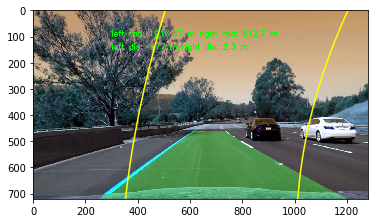

In [15]:
# process test images
#for fname in images:
L = Line()
R = Line()
img = cv2.imread('test_images/test6.jpg')

undist = undistort(img)
prep_img = preprocess_img(img)
detect_start(prep_img, L, R, 'output_images/left_fitx_right_fitx.jpg')

#print ('L ', L.recent_xfitted)
#print ('R ', R.recent_xfitted)

result = draw_lane(undist, prep_img, L,  R)
plt.imshow(result)
plt.savefig('output_images/test4_final_lane.jpg')

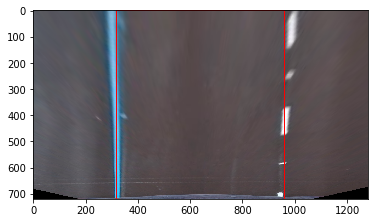

In [23]:
img2 = cv2.imread('test_images/straight_lines1.jpg')

shape = img2.shape
vertices = np.float32([[320, 0],[320, 720],[960, 720],[960, 0]])
undist2 = undistort(img2)
warp2 = warp(undist2)
draw_lines(warp2, vertices)
plt.imshow(warp2)
plt.savefig('output_images/warped_undistorted.jpg')

In [17]:
def process_image(img):
    global LLine
    global RLine
    undist = undistort(img)
    prep_img = preprocess_img(img)
    if LLine.detected == False or RLine.detected == False:
        print('LL: ', LLine.detected, 'RL: ', RLine.detected, '-> start new detection cycle')
        detect_start(prep_img, LLine, RLine)
    else:
        detect_next(prep_img, LLine, RLine)
    result = draw_lane(undist, prep_img, LLine,  RLine)
    return result

In [24]:
LLine = Line()
RLine = Line()

out_dir='./'
output = out_dir + 'processed_challenge_video.mp4'
clip = VideoFileClip('challenge_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

LL:  False RL:  False -> start new detection cycle
[MoviePy] >>>> Building video ./processed_challenge_video.mp4
[MoviePy] Writing video ./processed_challenge_video.mp4


  6%|▌         | 30/485 [00:05<01:16,  5.97it/s]

Lane width  3.36322896852  not plauible -> reject line
1  detections missed
Lane width  3.36322896852  not plauible -> reject line
1  detections missed
Lane width  3.37922855063  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.37922855063  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


  6%|▋         | 31/485 [00:05<01:16,  5.92it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  3.3031033721  not plauible -> reject line
1  detections missed
Lane width  3.3031033721  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


  7%|▋         | 34/485 [00:05<01:18,  5.76it/s]

Lane width  3.34504369515  not plauible -> reject line
1  detections missed
Lane width  3.34504369515  not plauible -> reject line
1  detections missed
Lane width  3.34497784685  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.34497784685  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


  7%|▋         | 35/485 [00:06<01:18,  5.74it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  3.30415018269  not plauible -> reject line
1  detections missed
Lane width  3.30415018269  not plauible -> reject line
1  detections missed


  8%|▊         | 37/485 [00:06<01:14,  6.02it/s]

Lane width  3.14457058374  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.14457058374  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle
Lane width  3.19286324059  not plauible -> reject line
1  detections missed
Lane width  3.19286324059  not plauible -> reject line
1  detections missed


  8%|▊         | 39/485 [00:06<01:34,  4.73it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.33268601799  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.33268601799  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


  8%|▊         | 41/485 [00:07<01:25,  5.19it/s]

LL:  False RL:  False -> start new detection cycle
Radius  96.754485089  not plauible -> reject line
1  detections missed
Lane width  3.31525168897  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  5.41240906018  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.41240906018  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


  9%|▊         | 42/485 [00:07<01:21,  5.43it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.28984337083  not plauible -> reject line
1  detections missed
Lane width  5.28984337083  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


  9%|▉         | 44/485 [00:07<01:24,  5.22it/s]

Lane width  3.32638789811  not plauible -> reject line
1  detections missed
Lane width  3.32638789811  not plauible -> reject line
1  detections missed
Lane width  3.2488716958  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.2488716958  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


  9%|▉         | 46/485 [00:08<01:19,  5.51it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  3.24684657706  not plauible -> reject line
1  detections missed
Lane width  3.24684657706  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


 10%|█         | 49/485 [00:08<01:17,  5.62it/s]

Lane width  5.03358828512  not plauible -> reject line
1  detections missed
Lane width  5.03358828512  not plauible -> reject line
1  detections missed
Lane width  5.0802792188  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.0802792188  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 11%|█         | 51/485 [00:08<01:18,  5.55it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.53383496471  not plauible -> reject line
1  detections missed
Lane width  4.53383496471  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


 11%|█         | 54/485 [00:09<01:16,  5.64it/s]

Lane width  4.83373307728  not plauible -> reject line
1  detections missed
Lane width  4.83373307728  not plauible -> reject line
1  detections missed
Lane width  4.74596081676  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.74596081676  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 11%|█▏        | 55/485 [00:09<01:17,  5.54it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.40131328857  not plauible -> reject line
1  detections missed
Lane width  5.40131328857  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


 12%|█▏        | 56/485 [00:09<01:18,  5.44it/s]

Lane width  4.4457633784  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.4457633784  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle
Lane width  4.45612835289  not plauible -> reject line
1  detections missed
Lane width  4.45612835289  not plauible -> reject line
1  detections missed


 12%|█▏        | 58/485 [00:10<01:17,  5.48it/s]

LL:  False RL:  False -> start new detection cycle
Line tolerance check for  2.52464050897  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  True -> start new detection cycle
Lane width  2.57109017945  not plauible -> reject line
1  detections missed
Lane width  2.57109017945  not plauible -> reject line
1  detections missed


 12%|█▏        | 60/485 [00:10<01:16,  5.54it/s]

LL:  False RL:  True -> start new detection cycle
Lane width  2.71239346537  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  2.71239346537  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 13%|█▎        | 63/485 [00:11<01:15,  5.58it/s]

Lane width  3.37358073676  not plauible -> reject line
1  detections missed
Lane width  3.37358073676  not plauible -> reject line
1  detections missed
Line tolerance check for  1.00481113793  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 13%|█▎        | 64/485 [00:11<01:14,  5.62it/s]

LL:  False RL:  True -> start new detection cycle
Lane width  5.18959833743  not plauible -> reject line
1  detections missed
Lane width  5.18959833743  not plauible -> reject line
1  detections missed


 14%|█▍        | 67/485 [00:11<01:13,  5.72it/s]

Lane width  5.19173392833  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.19173392833  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle
Line tolerance check for  0.913258008748  failed -> reject line
1  detections missed
Line tolerance check for  2.7567893636  failed -> reject line
1  detections missed


 14%|█▍        | 68/485 [00:12<01:14,  5.60it/s]

LL:  False RL:  False -> start new detection cycle
Line tolerance check for  0.844851482101  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
Line tolerance check for  2.80334458386  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 14%|█▍        | 69/485 [00:12<01:20,  5.17it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.75568201715  not plauible -> reject line
1  detections missed
Lane width  4.75568201715  not plauible -> reject line
1  detections missed


 14%|█▍        | 70/485 [00:12<01:31,  4.53it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.82513950877  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.82513950877  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 15%|█▍        | 71/485 [00:12<01:34,  4.40it/s]

LL:  False RL:  False -> start new detection cycle
Line tolerance check for  2.53652669706  failed -> reject line
1  detections missed


 15%|█▌        | 74/485 [00:13<01:19,  5.20it/s]

Line tolerance check for  2.507650625  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  True -> start new detection cycle


 24%|██▎       | 114/485 [00:20<01:03,  5.81it/s]

Radius  98.4552239196  not plauible -> reject line
1  detections missed
Radius  98.138046019  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 24%|██▎       | 115/485 [00:20<01:03,  5.82it/s]

LL:  False RL:  True -> start new detection cycle
Radius  65.4042622978  not plauible -> reject line
1  detections missed
Lane width  3.36914456218  not plauible -> reject line
1  detections missed
LL:  False RL:  True -> start new detection cycle


 28%|██▊       | 134/485 [00:23<00:58,  5.98it/s]

Lane width  3.35575921193  not plauible -> reject line
1  detections missed
Lane width  3.35575921193  not plauible -> reject line
1  detections missed
Radius  88.6559510668  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  2.75938372802  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 28%|██▊       | 135/485 [00:23<01:01,  5.73it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  1.72700576829  not plauible -> reject line
1  detections missed
Lane width  1.72700576829  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  0.31583006042  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  0.31583006042  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 28%|██▊       | 137/485 [00:24<01:02,  5.60it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.99744819888  not plauible -> reject line
1  detections missed
Lane width  2.99744819888  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  0.12659830359  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  0.12659830359  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 29%|██▊       | 139/485 [00:24<01:11,  4.85it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.65083085247  not plauible -> reject line
1  detections missed
Lane width  2.65083085247  not plauible -> reject line
1  detections missed


 29%|██▉       | 140/485 [00:24<01:09,  5.00it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.38240868805  not plauible -> reject line
1  detections missed
Lane width  4.38240868805  not plauible -> reject line
1  detections missed


 29%|██▉       | 142/485 [00:25<01:04,  5.32it/s]

Lane width  4.47633314416  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.47633314416  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 31%|███       | 148/485 [00:26<01:03,  5.31it/s]

Line tolerance check for  2.56138352423  failed -> reject line
1  detections missed
Radius difference  337916.0136  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Radius difference  337916.0136  not plauible -> reject line
1  detections missed


 31%|███       | 149/485 [00:26<01:03,  5.33it/s]

LL:  False RL:  True -> start new detection cycle
Lane width  2.40795172024  not plauible -> reject line
1  detections missed
Lane width  2.40795172024  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 31%|███       | 151/485 [00:27<01:02,  5.38it/s]

Line tolerance check for  2.50196141328  failed -> reject line
1  detections missed


 33%|███▎      | 159/485 [00:28<00:57,  5.65it/s]

Radius difference  226237.289221  not plauible -> reject line
1  detections missed
Radius difference  226237.289221  not plauible -> reject line
1  detections missed


 73%|███████▎  | 355/485 [01:02<00:21,  5.93it/s]

Radius difference  323883.830642  not plauible -> reject line
1  detections missed
Radius difference  323883.830642  not plauible -> reject line
1  detections missed
Radius difference  272996.664173  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Radius difference  272996.664173  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 73%|███████▎  | 356/485 [01:02<00:22,  5.82it/s]

LL:  False RL:  False -> start new detection cycle


 84%|████████▎ | 405/485 [01:11<00:13,  5.93it/s]

Line tolerance check for  2.53299039421  failed -> reject line
1  detections missed
Line tolerance check for  2.52608728066  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 84%|████████▍ | 407/485 [01:11<00:13,  5.64it/s]

LL:  False RL:  True -> start new detection cycle
Lane width  1.8434763904  not plauible -> reject line
1  detections missed
Lane width  1.8434763904  not plauible -> reject line
1  detections missed
LL:  False RL:  True -> start new detection cycle
Lane width  1.86060602591  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  1.86060602591  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 85%|████████▍ | 410/485 [01:12<00:13,  5.66it/s]

LL:  False RL:  False -> start new detection cycle


 85%|████████▍ | 412/485 [01:12<00:12,  5.76it/s]

Line tolerance check for  2.56535776015  failed -> reject line
1  detections missed
Line tolerance check for  2.60293123179  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 85%|████████▌ | 413/485 [01:12<00:12,  5.69it/s]

LL:  False RL:  True -> start new detection cycle
Line tolerance check for  2.62911260773  failed -> reject line
1 

 86%|████████▌ | 415/485 [01:13<00:12,  5.64it/s]

 detections missed
Line tolerance check for  2.63909328307  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  True -> start new detection cycle
Line tolerance check for  2.52092778514  failed -> reject line
1  detections missed


 86%|████████▌ | 417/485 [01:13<00:12,  5.64it/s]

LL:  False RL:  True -> start new detection cycle
Lane width  1.91453524637  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  1.91453524637  not plauible -> reject line
1  detections missed
LL:  False RL:  True -> start new detection cycle
Lane width  1.9039788691  not plauible -> reject line
1  detections missed
Lane width  1.9039788691  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 86%|████████▋ | 419/485 [01:13<00:11,  5.61it/s]

LL:  False RL:  False -> start new detection cycle
Line tolerance check for  2.50753818229  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  True -> start new detection cycle
Lane width  1.95013794344  not plauible -> reject line
1  detections missed
Lane width  1.95013794344  not plauible -> reject line
1  detections missed


 87%|████████▋ | 421/485 [01:14<00:11,  5.60it/s]

LL:  False RL:  True -> start new detection cycle
Lane width  1.94964589162  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  1.94964589162  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle
Lane width  2.14329556295  not plauible -> reject line
1  detections missed
Lane width  2.14329556295  not plauible -> reject line
1  detections missed


 87%|████████▋ | 423/485 [01:14<00:11,  5.61it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.3095016554  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  2.3095016554  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 87%|████████▋ | 424/485 [01:14<00:11,  5.43it/s]

Lane width  2.37234108921  not plauible -> reject line
1  detections missed
Lane width  2.37234108921  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  2.34909966861  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  2.34909966861  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 88%|████████▊ | 426/485 [01:14<00:10,  5.41it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.2618017482  not plauible -> reject line
1  detections missed
Lane width  2.2618017482  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  2.24757190534  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  2.24757190534  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 88%|████████▊ | 428/485 [01:15<00:10,  5.33it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.32128370978  not plauible -> reject line
1  detections missed
Lane width  2.32128370978  not plauible -> reject line
1  detections missed


 88%|████████▊ | 429/485 [01:15<00:11,  4.90it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.2819372333  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  2.2819372333  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 89%|████████▊ | 430/485 [01:15<00:11,  4.78it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  2.35059605275  not plauible -> reject line
1  detections missed
Lane width  2.35059605275  not plauible -> reject line
1  detections missed


 89%|████████▉ | 431/485 [01:16<00:12,  4.39it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.7054771629  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.7054771629  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 89%|████████▉ | 432/485 [01:16<00:11,  4.44it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.75297125138  not plauible -> reject line
1  detections missed
Lane width  4.75297125138  not plauible -> reject line
1  detections missed


 89%|████████▉ | 433/485 [01:16<00:11,  4.36it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.8222004673  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.8222004673  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 89%|████████▉ | 434/485 [01:16<00:11,  4.41it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.89210844074  not plauible -> reject line
1  detections missed
Lane width  4.89210844074  not plauible -> reject line
1  detections missed


 90%|████████▉ | 435/485 [01:16<00:11,  4.52it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.96458415645  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.96458415645  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 90%|████████▉ | 436/485 [01:17<00:10,  4.56it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.01537188415  not plauible -> reject line
1  detections missed
Lane width  5.01537188415  not plauible -> reject line
1  detections missed


 90%|█████████ | 437/485 [01:17<00:10,  4.50it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.2564752568  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.2564752568  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 90%|█████████ | 438/485 [01:17<00:10,  4.41it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.29486891797  not plauible -> reject line
1  detections missed
Lane width  5.29486891797  not plauible -> reject line
1  detections missed


 91%|█████████ | 439/485 [01:17<00:10,  4.46it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.25781531983  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.25781531983  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 91%|█████████ | 440/485 [01:18<00:10,  4.39it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.19260119529  not plauible -> reject line
1  detections missed
Lane width  5.19260119529  not plauible -> reject line
1  detections missed


 91%|█████████ | 441/485 [01:18<00:10,  4.38it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.25056364887  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.25056364887  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 91%|█████████ | 442/485 [01:18<00:09,  4.46it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.23252202633  not plauible -> reject line
1  detections missed
Lane width  5.23252202633  not plauible -> reject line
1  detections missed


 91%|█████████▏| 443/485 [01:18<00:09,  4.28it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.26366795397  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.26366795397  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 92%|█████████▏| 444/485 [01:19<00:09,  4.20it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.19372126728  not plauible -> reject line
1  detections missed
Lane width  5.19372126728  not plauible -> reject line
1  detections missed


 92%|█████████▏| 445/485 [01:19<00:09,  4.32it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  3.09797304261  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.09797304261  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 92%|█████████▏| 446/485 [01:19<00:08,  4.38it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  3.07310496599  not plauible -> reject line
1  detections missed
Lane width  3.07310496599  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


 92%|█████████▏| 447/485 [01:19<00:08,  4.59it/s]

Lane width  3.12953177625  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.12953177625  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 92%|█████████▏| 448/485 [01:19<00:08,  4.49it/s]

Lane width  3.19412671855  not plauible -> reject line
1  detections missed
Lane width  3.19412671855  not plauible -> reject line
1  detections missed


 93%|█████████▎| 449/485 [01:20<00:08,  4.37it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  3.33833677264  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.33833677264  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 93%|█████████▎| 450/485 [01:20<00:07,  4.61it/s]

Lane width  3.38298124238  not plauible -> reject line
1  detections missed
Lane width  3.38298124238  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


 94%|█████████▍| 455/485 [01:21<00:05,  5.39it/s]

Line tolerance check for  2.51186223232  failed -> reject line
1  detections missed


 96%|█████████▌| 466/485 [01:23<00:03,  5.65it/s]

Line tolerance check for  2.50438934916  failed -> reject line
1  detections missed
Line tolerance check for  2.54125690027  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 96%|█████████▋| 467/485 [01:23<00:03,  5.55it/s]

LL:  True RL:  False -> start new detection cycle


 97%|█████████▋| 469/485 [01:23<00:03,  4.99it/s]

Line tolerance check for  2.51001561036  failed -> reject line
1  detections missed


 97%|█████████▋| 471/485 [01:24<00:02,  5.29it/s]

Line tolerance check for  2.52611936776  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  True RL:  False -> start new detection cycle


 99%|█████████▉| 479/485 [01:25<00:01,  5.68it/s]

Line tolerance check for  1.19690113737  failed -> reject line
1  detections missed
Line tolerance check for  2.50265639047  failed -> reject line
1  detections missed
Line tolerance check for  2.6262309894  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 99%|█████████▉| 480/485 [01:25<00:00,  5.49it/s]

LL:  True RL:  False -> start new detection cycle
Lane width  5.94606604082  not plauible -> reject line
1  detections missed
Radius  12.9578489546  not plauible -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle
Lane width  6.00113051434  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  6.00113051434  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 99%|█████████▉| 482/485 [01:26<00:00,  5.54it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  6.03073503447  not plauible -> reject line
1  detections missed
Lane width  6.03073503447  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  5.93256422526  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.93256422526  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


100%|█████████▉| 484/485 [01:26<00:00,  5.34it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  5.97039991356  not plauible -> reject line
1  detections missed
Lane width  5.97039991356  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle
Lane width  5.97039991356  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  5.97039991356  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


100%|██████████| 485/485 [01:26<00:00,  5.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_challenge_video.mp4 

CPU times: user 2min 51s, sys: 7.16 s, total: 2min 58s
Wall time: 1min 28s
